# MSC Geomet - Example with Radar Imagery from WMS

This notebook provides an example of how to use the Meteorological Service of Canada's (MSC) [Geomet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/#msc-geomet "MSC Geomet Open Documentation") platform's web map service (WMS) with Python. 

The WMS provides access to georeferenced map images, also known as raster images or tiles.  These display hydro-meteorological variables from multiple MSC monitoring and numerical modelling systems and their related products.  Included with the map images is descriptive information, i.e., metadata, that includes attributes describing each of the different map images and how they should be displayed.  Together, the descriptive information and images are called layers. 

Layers can be requested from the WMS in real-time, as they are updated, for use in any number of mapping applications.  

This example will show how to request NEXRAD radar imagery tiles and plot them on a map using Python tools.

<img src="ontario-snow-storm-2022-01-17.gif" alt="Animated RADAR imagery captured during the January 2022 snow storm that passed through Ontario" title="Snow Storm, Ontario, January 17, 2022"/>


## Requirements

First, we import all necessary Python libraries.  Some of these are standard Python libraries, while others are third-party libraries that must first be installed in your Python environment, namely [OWSLib](https://geopython.github.io/OWSLib/index.html "OWSLib Documentation"), which stands for the Open Geospatial Consortium (OGC) web service and which will be used for accessing the WMS, and also [Matplotlib](https://matplotlib.org/stable/index.html "Matplotlib Documentation") and [Cartopy](https://scitools.org.uk/cartopy/docs/v0.15/index.html# "Cartopy Documentation"), which are more commonly used libraries and which will be used for plotting.

In [1]:
# data
import warnings
import re
import time
from datetime import datetime, timedelta

# web map services 
from owslib.wms import WebMapService

# plotting
from IPython.display import Image
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

## Layers and Metadata

To see what products MSC Geomet's WMS has to offer, let's first connect and explore what is available.  

Note that the OWSLib may display a lot of warnings, depending on the configuration of the WMS server itself.  These do not affect performance, but can be annoying; however, we can ignore those.

In [2]:
# Ignore warnings from the OWSLib module
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

# Connect to WMS 
geomet_url = 'https://geo.weather.gc.ca/geomet'
wms = WebMapService(geomet_url, timeout=300)

The WMS metadata is stored in a Python OrderedDict.  It can be accessed by iterating through the `wms.contents`, converted to a list, but there's a lot in there, so the list will be very long.  We can take a peak at a subset instead.

In [3]:
layers = list(wms.contents)
for layer in layers[0:10]: # first ten
    print(layer) 

Regional Deterministic Prediction System (RDPS) [10 km]
RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
CGSL.ETA_ICEC
CGSL.ETA_ICEPRS
CGSL.ETA_ICESTG
CGSL.ETA_ICET
CGSL.ETA_ICETK
CGSL.ETA_UICE
CGSL.ETA_UOGRD
CGSL.ETA_UU


When you call the WMS contents directly, you only get the layer names (as strings).  There's additional metadata though, and to access this, you can pass the layer name to the WMS directly.  

Let's start with the very first layer and inspect it's metadata:

In [4]:
layer_name = layers[0]
layer = wms[layer_name]
print(layer)

Layer Name: Regional Deterministic Prediction System (RDPS) [10 km] Title: Regional Deterministic Prediction System (RDPS) [10 km]


By looking at a specific layer, we now see both a name and a title. We can also call them directly.

In [5]:
print(layer.name)
print(layer.title)

Regional Deterministic Prediction System (RDPS) [10 km]
Regional Deterministic Prediction System (RDPS) [10 km]


In this case, they're the same.  Each major monitoring or modelling system is distributed as a layer within the WMS.  Each system layer is the parent of various children layers.

In [6]:
print(layer)
for child in layer.children:
    print(child)

Layer Name: Regional Deterministic Prediction System (RDPS) [10 km] Title: Regional Deterministic Prediction System (RDPS) [10 km]
Layer Name: RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL) Title: RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
Layer Name: RDPS convective variables Title: RDPS convective variables
Layer Name: RDPS diagnostic variables Title: RDPS diagnostic variables
Layer Name: RDPS Title: RDPS
Layer Name: RDPS at pressure levels Title: RDPS at pressure levels


There can also be additional children layers at multiple levels.  

In [7]:
print("Level 1: ", layer.name) # parent layer

# for first two chilren layers...
for i, child_layer_1 in enumerate(layer.children[0:2]): 
    print(f"  Level {i}:", child_layer_1.name)
    # ... show first 5 sub-children
    for j, child_layer_2 in enumerate((child_layer_1.children)[0:5]):
        print(f"    Level {j}:", child_layer_2.name)

Level 1:  Regional Deterministic Prediction System (RDPS) [10 km]
  Level 0: RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
    Level 0: CGSL.ETA_ICEC
    Level 1: CGSL.ETA_ICEPRS
    Level 2: CGSL.ETA_ICESTG
    Level 3: CGSL.ETA_ICET
    Level 4: CGSL.ETA_ICETK
  Level 1: RDPS convective variables
    Level 0: RDPS.CONV_KINDEX.PT3H
    Level 1: RDPS.CONV_ML-CAPE
    Level 2: RDPS.CONV_ML-CIN
    Level 3: RDPS.CONV_ML-EL-HGT
    Level 4: RDPS.CONV_ML-LCL-HGT


Names of the actual hydro-meteorological variables with georeferenced map images are typically given as acronyms that describe the monitoring or modelling system and the variable (e.g., *SYSTEM.VARIABLE*).  

These acronymns may not be very helpful for those unfamiliar with them, but you can instead inspect and search the rest of the layer metadata. 

For example, to find layers of the WMS that include RADAR info, we can first try searching for the term in the layer names.

In [8]:
for layer in wms.contents:
    if "RADAR" in layer.upper():
        print(layer)

Weather Radar
North American radar composite (1 km)
RADAR_1KM_RRAI
RADAR_1KM_RSNO
RADAR_COVERAGE_RRAI
RADAR_COVERAGE_RRAI.INV
RADAR_COVERAGE_RSNO
RADAR_COVERAGE_RSNO.INV


This worked well in this case, where the term "RADAR" is directly in the layer name, but that's rarely the case.  Instead, you can search other metadata fields, notably the `keywords` field.

<div class="alert alert-block alert-warning">
<b>Important:</b> The Open Geospatial Consortium (OGC) Web Map Service (WMS) standards have been updated over time, and the OGCLib provides support for both previous and current versions, 1.1.1 and 1.3.0, respectively.  There are noteable differences between these different versions, including differences in how query strings are prepared and available metadata, how it is presented, ordered and even the available fields that can be accessed.  Users must consider this when connecting and accessing WMS.
</div>

To view all available fields, use `vars(layer)`. A subset of the available fields are listed in the function below: 

In [9]:
layer = wms['RADAR_1KM_RRAI']

print("Name:      ", layer.name)
print("Title:     ", layer.title)
print("Abstract:  ", layer.abstract)
print("Keywords:  ", layer.keywords)
print("BBox:      ", layer.boundingBox)
print("Timestamps:", layer.timepositions)

Name:       RADAR_1KM_RRAI
Title:      RADAR - Radar precipitation rate (Rain) (1 km) [mm/h]
Abstract:   Composite of American and Canadian weather radars updated every 10 minutes
Keywords:   ['Atmospheric conditions Meteorology Weather', ' Radar', ' Remote sensing', ' Weather']
BBox:       (-180.0, -90.0, 180.0, 90.0, 'EPSG:4326')
Timestamps: ['2022-01-20T15:50:00Z/2022-01-20T18:50:00Z/PT10M']


From this we can see that the 'RADAR_1KM_RRAI' layer contains radar precipitation rates from both US and Canadian radars.  This is what we'll use for the remainded of this example.

But before we get to plotting, we'll first create some functions to help us more readily connect to the WMS and read and display some important layer attributes.  

We'll somewhat modify how we connect to the WMS.  Earlier, we connected directly to the Geomet base URL without passing any query string parameters to it.  A query string adds to the base URL and adds more precision to our request.  

In [10]:
def connect_to_wms(url='https://geo.weather.gc.ca/geomet', version='1.3.0', timeout=120, rparameters=None):
    """
    Connects to the Web Map Service
    
        url         : Geomet URL, str
        version     : 1.1.1 or 1.3.0, version of the 
                      Open Geospatial Consortium (OGC) 
                      Web Map Service standard (not 
                      related to Geomet specifically)
        timeout     : Timeout maximum (seconds)
        rparameters : Parameters to attach to the WMS request URL
        
    """
    
    url = url + '?' + "&".join([f"{key}={value}" for key, value in rparameters.items()])
    wms = WebMapService(url, version=version, timeout=timeout)
    return wms

Some important query parameters when connecting to the Geomet WMS include:

- "service", which allows users to select the web service (e.g., the WMS, as opposed to other available Geomet web services) 
- "GetCapabilities", which provides information on the WMS and all the map layers within it (this is where the layer metadata comes from)
- "layer", which allows us to request a specific layer, rather than the entire web service

Additional query parameters are also possible.

<div class="alert alert-block alert-warning">
<b>Important:</b> It is recommended to include query parameters when connecting to the Geomet WMS.  This will connect directly to the requested service and to the specified layer's metadata and result in a noticeably faster connection.  It is also the case that some layers are not updated as frequently in the base "GetCapabilities" document, but connecting directly to the layer will ensure the most recent version of the layer and associated metadata. 
</div>

Two other functions will allow us to access important parameters in a consistent format.

In [11]:
def time_parameters(layer):
    """
    Extract temporal information from metadata
    
        layer    :    Geomet layer
        
    """
    start_time, end_time, interval = (layer
                                      .timepositions[0]
                                      .split('/')
                                      )
    iso_format = '%Y-%m-%dT%H:%M:%SZ' # required by OWSLib
    start = datetime.strptime(start_time, iso_format)
    end = datetime.strptime(end_time, iso_format)
    interval = int(re.sub(r'\D', '', interval))

    return dict(start=start, end=end, interval=interval)

def bounding_box(layer, WGS84=True):
    """
    Extract bounding box
    
        layer    :    Geomet layer
        WGS84    :    Boolean value, specifying
                      whether the default WGS84
                      coordinate reference system (CRS)
                      should be returned, or the 
                      CRS of the data as-is
                      
    """
    
    if WGS84 is True:
        west, south, east, north = layer.boundingBoxWGS84
        bbox = dict(west=west, south=south, east=east, north=north)
    else:
        bbox_tup = wms[layer_name].boundingBox
        if len(bbox_tup) == 5: # this will address OGC WMS version 1.1.1
            west, south, east, north, crs = bbox_tup
            bbox = dict(west=west, south=south, east=east, north=north, crs=crs)
        elif len(bbox_tup) == 4: 
            west, south, east, north = bbox_tup
            bbox = dict(west=west, south=south, east=east, north=north)
        
    return bbox

def print_metadata(layer):
    print("Name:      ", layer.name)
    print("Title:     ", layer.title)
    print("Abstract:  ", layer.abstract)
    print("Keywords:  ", layer.keywords)
    
    timestamps = time_parameters(layer)
    print("Timestamps:")
    print("  Start:   ", timestamps['start'])
    print("  End:     ", timestamps['end'])
    print("  Interval:", timestamps['interval'])
    
    bbox = bounding_box(layer, WGS84=True)
    print("BBox WGS84:")
    print("  West:    ", bbox['west'])
    print("  South:   ", bbox['south'])
    print("  East:    ", bbox['east']) 
    print("  North:   ", bbox['north'])

<div class="alert alert-block alert-warning">
<b>Important:</b> For time varying data, it is important to reconnect to the WMS whenever interacting with it.  When you connect, the connection and all the layer metadata is a snapshot at that specific point in time that the connection was made.  It's not updated thereafter unless you reconnect to the WMS.  So if the metadata and data changes on the server, without reconnecting, you're time-varying metadata will not be up-to-date.
</div>

Let's test our functions out:

In [12]:
layer_name = 'RADAR_1KM_RRAI'

# prepare query
rparameters = dict(SERVICE='WMS', REQUEST='GetCapabilities', LAYER=layer_name)

# connect
wms = connect_to_wms('https://geo.weather.gc.ca/geomet',
                    version='1.3.0', timeout=300, rparameters=rparameters)

In [13]:
wms.contents

OrderedDict([('Weather Radar',
              <owslib.map.wms130.ContentMetadata at 0x19a0e5a5700>),
             ('North American radar composite (1 km)',
              <owslib.map.wms130.ContentMetadata at 0x19a0e5a5f70>),
             ('RADAR_1KM_RRAI',
              <owslib.map.wms130.ContentMetadata at 0x19a0e5c0070>)])

In [14]:
# request layer
layer = wms[layer_name]
print_metadata(layer)

Name:       RADAR_1KM_RRAI
Title:      RADAR - Radar precipitation rate (Rain) (1 km) [mm/h]
Abstract:   Composite of American and Canadian weather radars updated every 10 minutes
Keywords:   ['Atmospheric conditions Meteorology Weather', ' Radar', ' Remote sensing', ' Weather']
Timestamps:
  Start:    2022-01-20 15:50:00
  End:      2022-01-20 18:50:00
  Interval: 10
BBox WGS84:
  West:     -170.32
  South:    16.93
  East:     -50.0
  North:    67.19


We can connect and access the metadata, so we're now ready to plot the map images.

## Plotting

The WMS map images can be requested and plotted in several ways.  

First, we'll use the `getmap` method of the OWSLib WebMapService to retrieve the map tiles we're interested in, and then we'll display them with IPython.Display.Image for a quick look in our notebook.

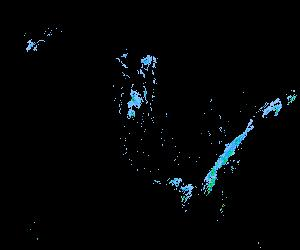

In [15]:
# prepare query
layer_name = 'RADAR_1KM_RRAI'

rparameters = dict(service='WMS', request='GetCapabilities', layer=layer_name)

# connect
wms = connect_to_wms('https://geo.weather.gc.ca/geomet',
                    version='1.3.0', timeout=300, rparameters=rparameters)
# get map
response = wms.getmap(layers=[layer_name],
                      format='image/jpeg',
                      srs='EPSG:4326',
                      bbox=(-170.32, 16.93, -50.0, 67.19),
                      size=(300,250),
                      transparent=True)

# show
Image(response.read(), width = 500, height = 300)

This gives only a sample of what the data looks like.  

The WMS map images can also be plotted using a combination of Matplotlib and Cartopy, which also give the ability to display other features and greater control over details.

The following function prepares a plot of the radar data, overlaid on a map.

In [16]:
def plot_map(wms, layer_name, vtime=None, bbox=None):
    """
    Connects to WMS, retrieves requested layer 
    and adds it to plot
    
    wms         :   Web Map Service
    layer_name  :   Layer name as string
    vtime       :   Valid time (i.e., time to request)
    bbox        :   Bounding box coordinates
    
    """
    
    fig = plt.figure(figsize=(12,12))
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    
    if bbox is None:
        bbox = bounding_box(wms[layer_name])
        west = bbox['west']
        south = bbox['south']
        east = bbox['east']
        north = bbox['north']
    else:
        west = bbox['west']
        south = bbox['south']
        east = bbox['east']
        north = bbox['north']
    
    ax.set_extent([west, east, south, north])
    
    fig.tight_layout(pad=2)

    # features
    
    edgecolor = 'black'
    
    # Cartopy features 
    ax.add_feature(cf.LAND, facecolor='silver', edgecolor=edgecolor)
    ax.add_feature(cf.COASTLINE, edgecolor=edgecolor)
    ax.add_feature(cf.LAKES, facecolor="white", edgecolor=edgecolor)
    
    
    # Natural Earth Features
    countries = cf.NaturalEarthFeature(
            category='cultural',
            name='admin_0_countries_lakes',
            scale='10m',
            edgecolor=edgecolor,
            facecolor='none')
    borders = cf.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            edgecolor=edgecolor,
            facecolor='none')

    ax.add_feature(countries)
    ax.add_feature(borders, linestyle='dashed')
    

    # Plot map image for specific time
    if vtime==None: # plot most recent
        t = time_parameters(wms[layer_name])
        iso_time = t['end'].strftime('%Y-%m-%dT%H:%M:%SZ')
    
    if isinstance(vtime, datetime):
        iso_time = vtime.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    ax.add_wms(wms=wms, layers=[layer_name], wms_kwargs = {'time' : iso_time}, zorder=10)
        
    ax.set_title(f'Radar Composite - {iso_time}')
          
    return plt

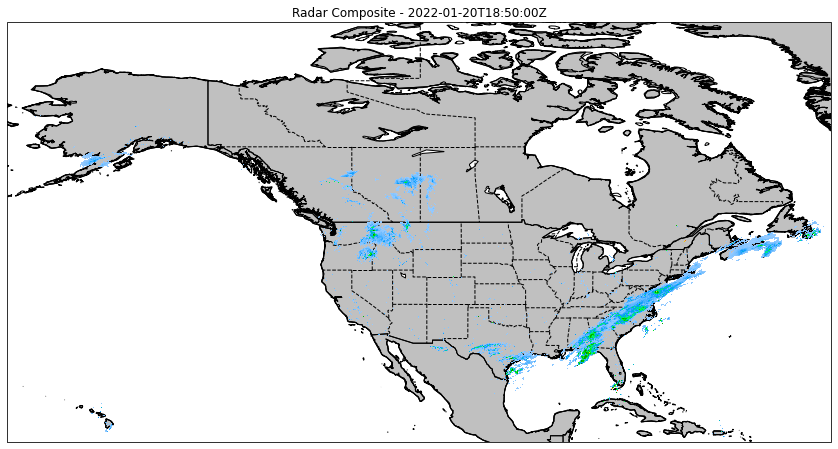

In [17]:
# prepare query
layer_name = 'RADAR_1KM_RRAI'

rparameters = dict(service='WMS', request='GetCapabilities', layer=layer_name)

# connect
wms = connect_to_wms('https://geo.weather.gc.ca/geomet',
                    version='1.3.0', timeout=300, rparameters=rparameters)

# create plot
p=plot_map(wms, layer_name)

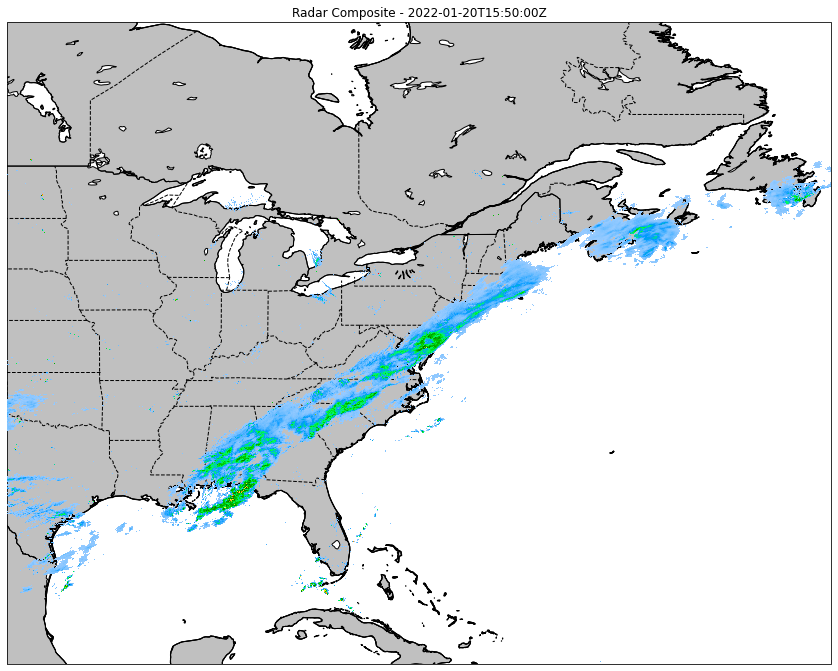

In [18]:
# create plot with starting time of map images and 
# bounding box specified as eastern North America

# prepare query
layer_name = 'RADAR_1KM_RRAI'
rparameters = dict(service='WMS', request='GetCapabilities', layer=layer_name)

# connect
wms = connect_to_wms('https://geo.weather.gc.ca/geomet',
                    version='1.3.0', timeout=300, rparameters=rparameters)

timestamps = time_parameters(wms[layer_name])

west = -100
south = 20
east = -52
north = 55
bbox = dict(north=north, south=south, east=east, west=west)

p=plot_map(wms, layer_name, timestamps['start'], bbox)

In [19]:
def create_multiple_maps(start_time, end_time, layer_name='RADAR_1KM_RRAI', prefix='IMG', delay=10, bbox=None, i=1, attempts=10):
    """
    This function allows production of
    multiple maps, between start_time and end_time,
    with a 10 minute delay between each to
    allow radar data to update
    
    start_time   :  Time of first image, UTC
    end_time     :  Time of last image, UTC
    layer_name   :  Name of layer to plot
    delay        :  Delay between maps, in minutes
    bbox         :  Bounding box coordinates
    i            :  Integer used to start file naming
    """
    vtime = start_time
    delay = 60 * delay
    attempt = 1
    while vtime <= end_time:

        try:
            # Creates plot and saves to working directory
            fn = f"{prefix}{i:03d}.png"
            p=plot_map(wms, layer_name, vtime, bbox)
            p.savefig(fn)
            
            # Prepare for next plot
            vtime = vtime+timedelta(minutes=10)
            i += 1
            attempt = 1
            
            if vtime <= end_time: # prevents sleeping at end_time
                print(f"Saved {vtime} as {fn} ... now waiting")
                time.sleep(delay)
            else:
                return True # finished
        except:
            # if plot fails, it could be that WMS not connecting, or
            # that data is not yet updated; this will wait 30 seconds
            # and try again
            attempt += 1
            if attempt > attempts:
                print(f"Failed {attempt} times for time {vtime}... aborting")
                return False # attempts exceeded
            else:
                print(f"Failed attempt {attempt} for time {vtime}... trying again in 30 seconds")
                time.sleep(30)
                pass
            
    return True

In [20]:
# prepare query
rparameters = dict(SERVICE='WMS', REQUEST='GetCapabilities', LAYER=layer_name)

# connect
wms = connect_to_wms('https://geo.weather.gc.ca/geomet',
                    version='1.3.0', timeout=300, rparameters=rparameters)

timestamps = time_parameters(wms[layer_name])

start_time = timestamps['end']
end_time = start_time + timedelta(minutes=10)
i = 1

west = -100
south = 20
east = -52
north = 55
bbox = dict(north=north, south=south, east=east, west=west)

# Commented out since this takes time to run, depending on "delay" parameter (in minutes)
#check = create_radar_maps(start_time, end_time, layer_name='RADAR_1KM_RRAI', prefix='IMG', delay=10, bbox=bbox, i=1)
#print("Did plots complete successfully? ", check)